# Comprehensive Model Training Analysis and Visualization

This notebook provides a complete analysis of all models trained in the CV1 Final Lab Part 2, including:

## Contents
1. **Setup and Imports** - Load necessary libraries
2. **TensorBoard Log Visualization** - Training/validation curves during training
3. **Optuna Hyperparameter Study Visualization** - Optimization history and hyperparameter importance
4. **Model Comparison** - Best validation accuracies from Optuna studies
5. **Final Test Set Evaluation** - Load best checkpoints and evaluate on test set
6. **Per-Class Performance Analysis** - Identify which classes are hard/easy for each model
7. **Summary Table** - Comprehensive results summary with insights

This notebook evaluates the **final test set accuracy** from the **best saved checkpoints**, providing a reproducible and comprehensive analysis of model performance.

## 1. Setup and Imports

In [110]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing import event_accumulator
import joblib
import optuna

# PyTorch imports for model evaluation
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# Import model architectures from models.py
from models import TwoLayerNet, ConvNet, ExtendedTwoLayerNet, ExtendedConvNet, build_model_from_params

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries and models imported successfully')


Libraries and models imported successfully


## 2. TensorBoard Log Visualization

This section reads the TensorBoard event files and visualizes the training curves for all models.


In [111]:
def find_latest_event_file(log_dir):
    """Find the most recent event file in a directory."""
    event_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]
    if not event_files:
        return None
    # Sort by modification time and return the most recent
    event_files_with_time = [(f, os.path.getmtime(os.path.join(log_dir, f))) for f in event_files]
    latest_file = max(event_files_with_time, key=lambda x: x[1])[0]
    return os.path.join(log_dir, latest_file)

def read_tensorboard_logs(log_dir):
    """Read TensorBoard event files from a directory (only the latest file)."""
    # Find the latest event file to avoid reading multiple training runs
    latest_event = find_latest_event_file(log_dir)
    if not latest_event:
        print(f"No event files found in {log_dir}")
        return {}
    
    ea = event_accumulator.EventAccumulator(latest_event)
    ea.Reload()
    
    data = {}
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        data[tag] = {
            'steps': [e.step for e in events],
            'values': [e.value for e in events]
        }
    return data

def find_latest_run(base_dir, model_name):
    """Find the latest run directory for a given model."""
    model_dir = os.path.join(base_dir, model_name.lower())
    if not os.path.exists(model_dir):
        return None
    runs = sorted(os.listdir(model_dir))
    if not runs:
        return None
    return os.path.join(model_dir, runs[-1])

# Read logs for all models
base_log_dir = 'runs'
models = ['twolayernet', 'convnet', 'extendedtwolayernet', 'extendedconvnet']
model_logs = {}

for model in models:
    log_dir = find_latest_run(base_log_dir, model)
    if log_dir:
        print(f"Reading logs for {model} from {log_dir}")
        model_logs[model] = read_tensorboard_logs(log_dir)
    else:
        print(f"No logs found for {model}")

print(f"\nLoaded logs for {len(model_logs)} models")


Reading logs for twolayernet from runs/twolayernet/2025-10-25_11-08-18
Reading logs for convnet from runs/convnet/2025-10-25_11-08-18
Reading logs for extendedtwolayernet from runs/extendedtwolayernet/2025-10-25_11-08-18
Reading logs for extendedconvnet from runs/extendedconvnet/2025-10-25_11-08-18

Loaded logs for 4 models


### 2.1 Training and Validation Loss Curves


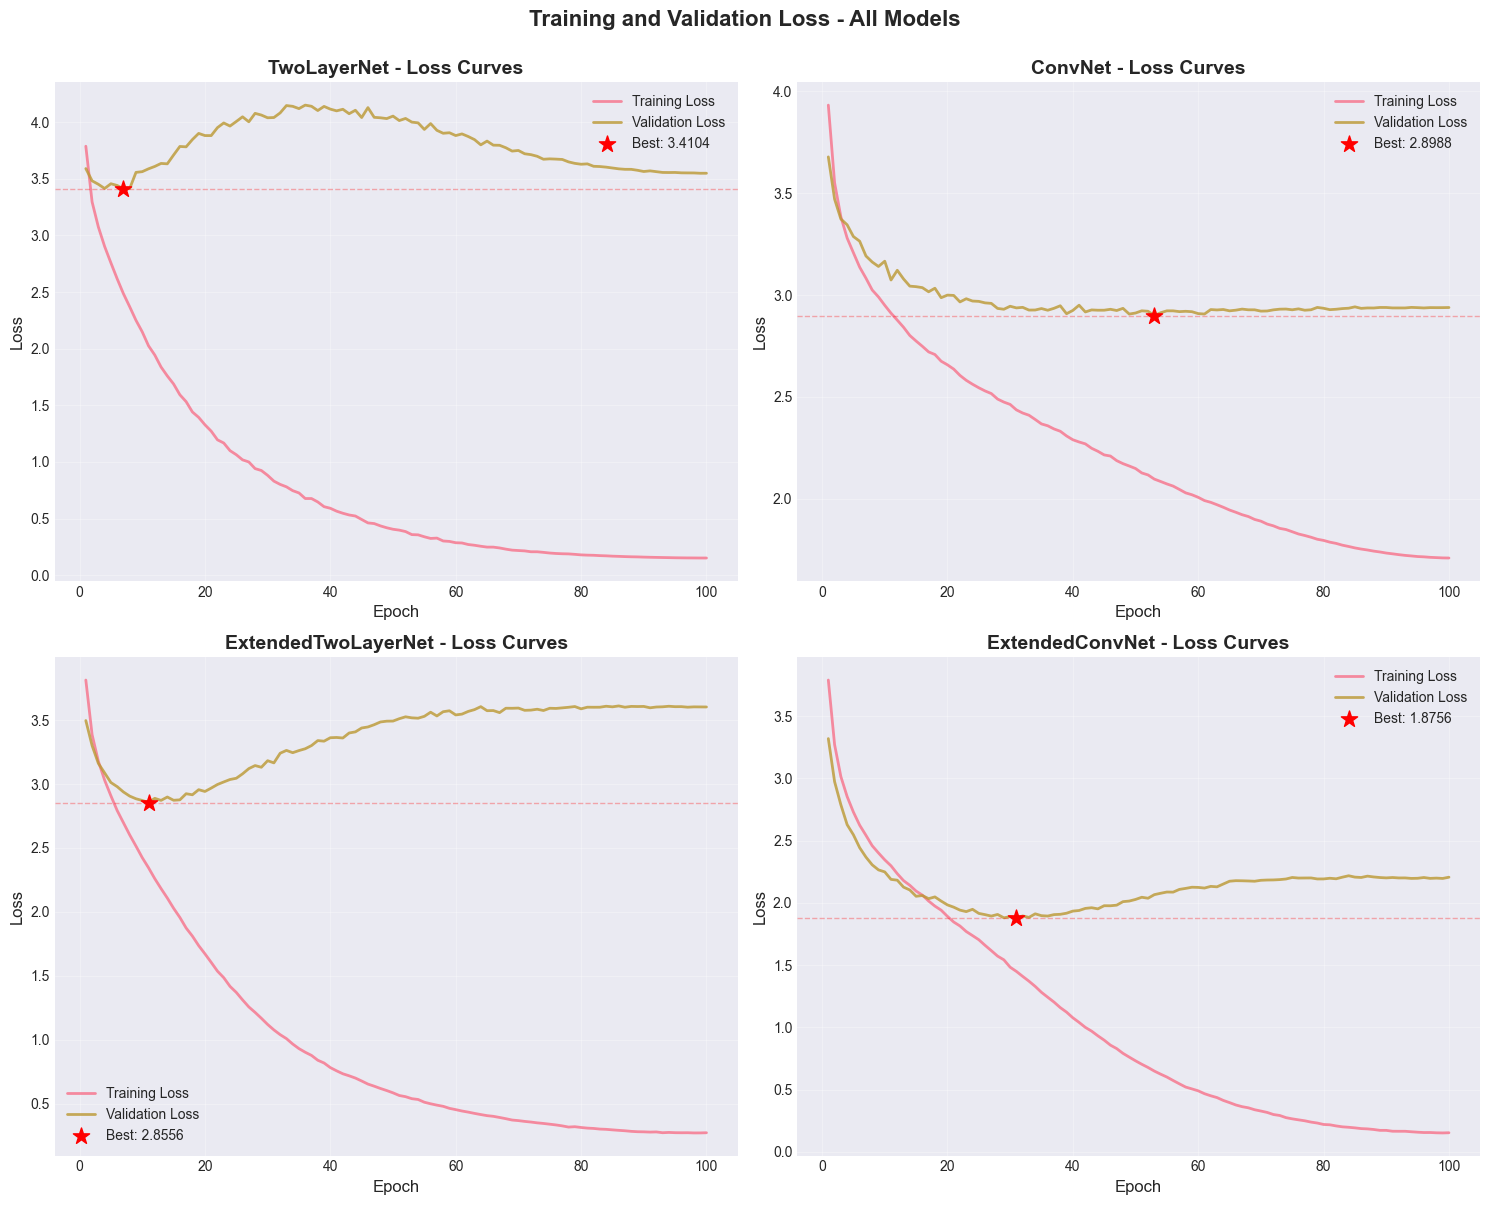

Figure saved as 'all_models_loss_curves.png'


In [112]:
# Plot training loss for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

model_names = {
    'twolayernet': 'TwoLayerNet',
    'convnet': 'ConvNet',
    'extendedtwolayernet': 'ExtendedTwoLayerNet',
    'extendedconvnet': 'ExtendedConvNet'
}

for idx, (model_key, logs) in enumerate(model_logs.items()):
    ax = axes[idx]
    
    # Plot training loss
    if 'Train/Loss' in logs:
        train_data = logs['Train/Loss']
        ax.plot(train_data['steps'], train_data['values'], 
                label='Training Loss', linewidth=2, alpha=0.8)
    
    # Plot validation loss if available
    if 'Val/Loss' in logs:
        val_data = logs['Val/Loss']
        ax.plot(val_data['steps'], val_data['values'], 
                label='Validation Loss', linewidth=2, alpha=0.8)
        
        # Find and mark the best (minimum) validation loss
        best_val_loss = min(val_data['values'])
        best_val_epoch = val_data['steps'][val_data['values'].index(best_val_loss)]
        ax.scatter([best_val_epoch], [best_val_loss], color='red', s=150, 
                   marker='*', zorder=5, label=f'Best: {best_val_loss:.4f}')
        ax.axhline(y=best_val_loss, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(f'{model_names.get(model_key, model_key)} - Loss Curves', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Training and Validation Loss - All Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('all_models_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'all_models_loss_curves.png'")


### 2.2 Training and Validation Accuracy Curves


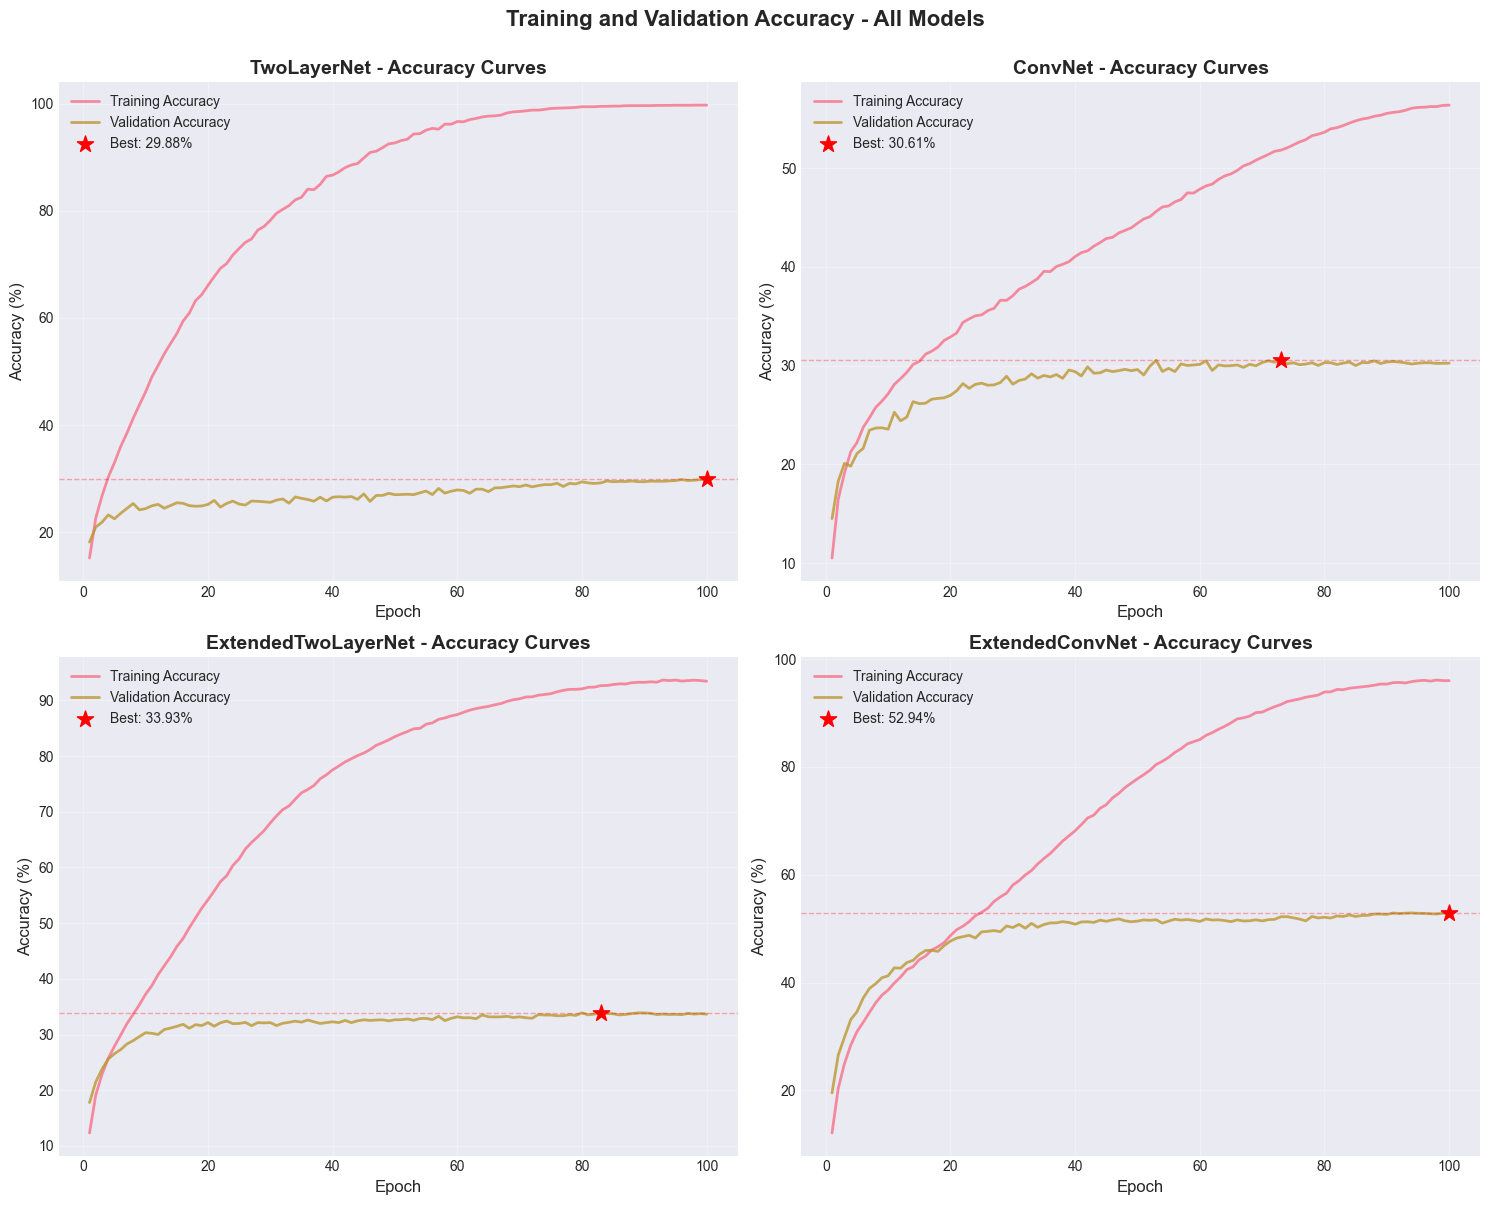

Figure saved as 'all_models_accuracy_curves.png'


In [113]:
# Plot accuracy for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (model_key, logs) in enumerate(model_logs.items()):
    ax = axes[idx]
    
    # Plot training accuracy
    if 'Train/Accuracy' in logs:
        train_data = logs['Train/Accuracy']
        ax.plot(train_data['steps'], train_data['values'], 
                label='Training Accuracy', linewidth=2, alpha=0.8)
    
    # Plot validation accuracy if available
    if 'Val/Accuracy' in logs:
        val_data = logs['Val/Accuracy']
        ax.plot(val_data['steps'], val_data['values'], 
                label='Validation Accuracy', linewidth=2, alpha=0.8)
        
        # Find and mark the best validation accuracy
        best_val_acc = max(val_data['values'])
        best_val_epoch = val_data['steps'][val_data['values'].index(best_val_acc)]
        ax.scatter([best_val_epoch], [best_val_acc], color='red', s=150, 
                   marker='*', zorder=5, label=f'Best: {best_val_acc:.2f}%')
        ax.axhline(y=best_val_acc, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(f'{model_names.get(model_key, model_key)} - Accuracy Curves', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Training and Validation Accuracy - All Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('all_models_accuracy_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'all_models_accuracy_curves.png'")


## 3. Optuna Hyperparameter Study Visualization

This section visualizes the hyperparameter optimization results from Optuna studies.


In [114]:
# Load Optuna studies
optuna_dir = 'optuna_studies'
study_files = {
    'TwoLayerNet': 'twolayernet_20251015_220546.pkl',
    'ConvNet': 'convnet_20251015_224750.pkl',
    'ExtendedTwoLayerNet': 'extendedtwolayernet_20251016_031355.pkl',
    'ExtendedConvNet': 'extendedconvnet_20251016_201838.pkl'
}

studies = {}
for model_name, pkl_file in study_files.items():
    pkl_path = os.path.join(optuna_dir, pkl_file)
    if os.path.exists(pkl_path):
        print(f"Loading study for {model_name} from {pkl_path}")
        studies[model_name] = joblib.load(pkl_path)
    else:
        print(f"Study file not found: {pkl_path}")

print(f"\nLoaded {len(studies)} Optuna studies")


Loading study for TwoLayerNet from optuna_studies/twolayernet_20251015_220546.pkl
Loading study for ConvNet from optuna_studies/convnet_20251015_224750.pkl
Loading study for ExtendedTwoLayerNet from optuna_studies/extendedtwolayernet_20251016_031355.pkl
Loading study for ExtendedConvNet from optuna_studies/extendedconvnet_20251016_201838.pkl

Loaded 4 Optuna studies


### 3.1 Optimization History


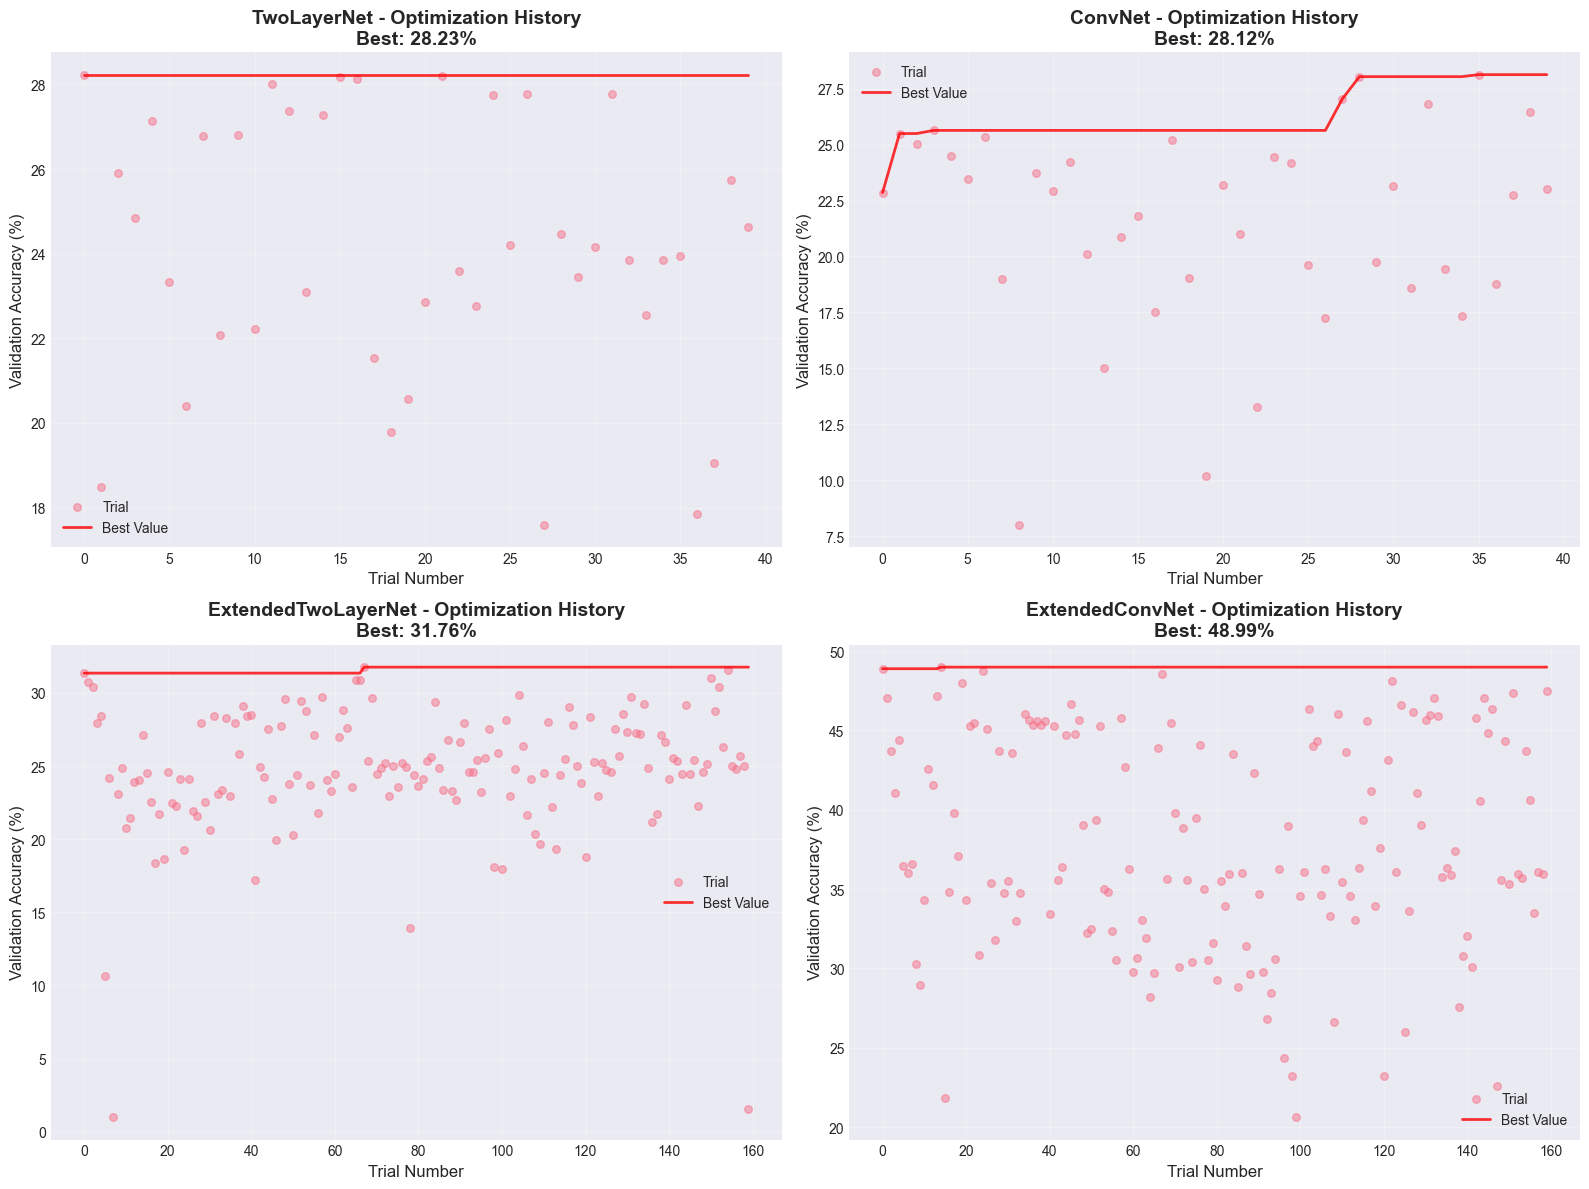

Figure saved as 'optuna_optimization_history.png'


In [115]:
# Plot optimization history for all studies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (model_name, study) in enumerate(studies.items()):
    ax = axes[idx]
    
    # Get trial values
    trial_values = [t.value for t in study.trials if t.value is not None]
    trial_numbers = [t.number for t in study.trials if t.value is not None]
    
    # Plot all trials
    ax.scatter(trial_numbers, trial_values, alpha=0.5, s=30, label='Trial')
    
    # Plot best value line
    best_values = []
    current_best = -np.inf
    for val in trial_values:
        current_best = max(current_best, val)
        best_values.append(current_best)
    
    ax.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best Value', alpha=0.8)
    
    ax.set_xlabel('Trial Number', fontsize=12)
    ax.set_ylabel('Validation Accuracy (%)', fontsize=12)
    ax.set_title(f'{model_name} - Optimization History\nBest: {study.best_value:.2f}%', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('optuna_optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'optuna_optimization_history.png'")


### 3.2 Best Hyperparameters Summary


In [116]:
# Print best hyperparameters for each model
print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOR EACH MODEL")
print("="*80)

for model_name, study in studies.items():
    print(f"\n{model_name}:")
    print(f"  Best Trial: #{study.best_trial.number}")
    print(f"  Best Validation Accuracy: {study.best_value:.2f}%")
    print(f"  Best Parameters:")
    for param, value in study.best_params.items():
        if isinstance(value, float):
            print(f"    {param}: {value:.6f}")
        else:
            print(f"    {param}: {value}")
    print("-"*80)

print("="*80)



BEST HYPERPARAMETERS FOR EACH MODEL

TwoLayerNet:
  Best Trial: #0
  Best Validation Accuracy: 28.23%
  Best Parameters:
    lr: 0.000561
    weight_decay: 0.000797
    optimizer_type: adam
    scheduler_type: cosine
    batch_size: 256
    hidden_size: 2048
--------------------------------------------------------------------------------

ConvNet:
  Best Trial: #35
  Best Validation Accuracy: 28.12%
  Best Parameters:
    lr: 0.004238
    weight_decay: 0.000734
    optimizer_type: adam
    scheduler_type: cosine
    batch_size: 256
--------------------------------------------------------------------------------

ExtendedTwoLayerNet:
  Best Trial: #67
  Best Validation Accuracy: 31.76%
  Best Parameters:
    lr: 0.000244
    weight_decay: 0.000775
    optimizer_type: adam
    scheduler_type: cosine
    batch_size: 128
    h1: 1536
    h2: 768
    h3: 384
    dropout: 0.164673
--------------------------------------------------------------------------------

ExtendedConvNet:
  Best Trial

## 4. Model Comparison

Final comparison of all models showing the best validation accuracies achieved.


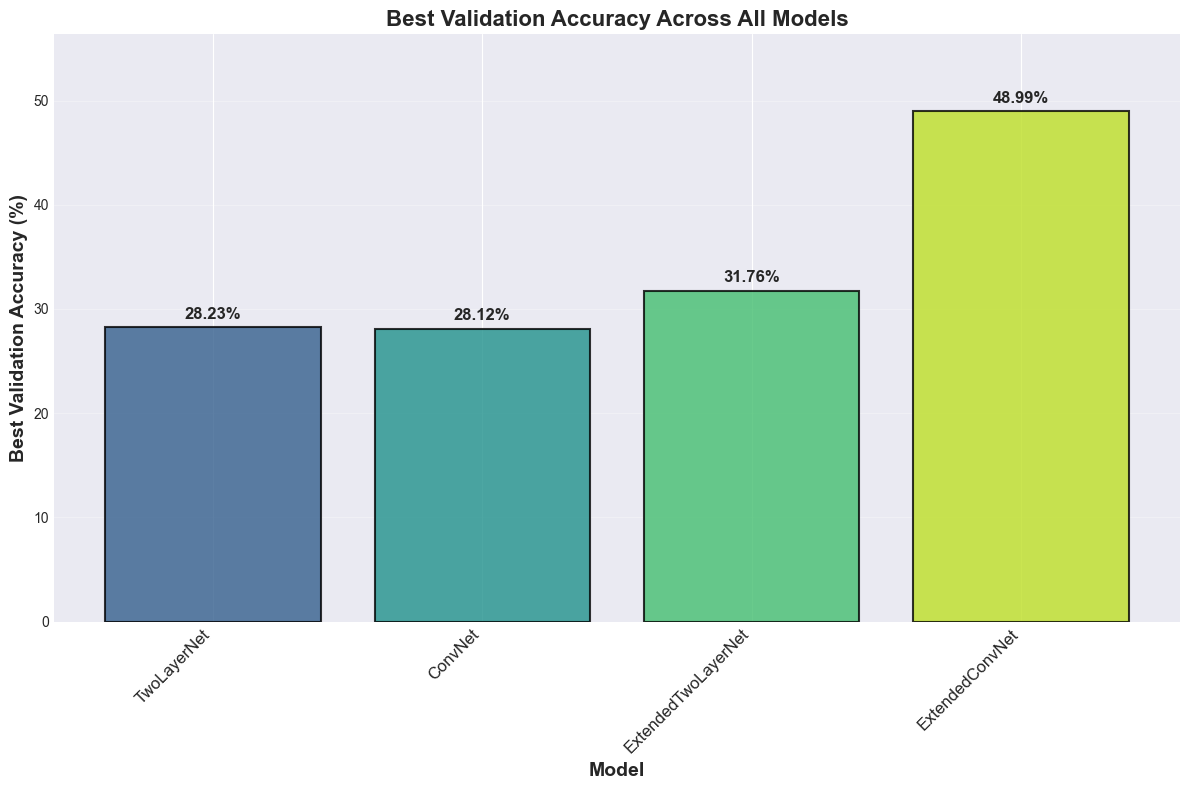

Figure saved as 'model_best_accuracy_comparison.png'

All visualizations completed successfully!


In [117]:
# Visualize best validation accuracy for all models
fig, ax = plt.subplots(figsize=(12, 8))

model_names_list = list(studies.keys())
best_accs = [studies[m].best_value for m in model_names_list]

# Create bar plot
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(model_names_list)))
bars = ax.bar(range(len(model_names_list)), best_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on top of bars
for i, (bar, acc) in enumerate(zip(bars, best_accs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Best Validation Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Best Validation Accuracy Across All Models', fontsize=16, fontweight='bold')
ax.set_xticks(range(len(model_names_list)))
ax.set_xticklabels(model_names_list, rotation=45, ha='right', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(best_accs) * 1.15)

plt.tight_layout()
plt.savefig('model_best_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'model_best_accuracy_comparison.png'")
print("\nAll visualizations completed successfully!")


### 3.3 Hyperparameter Importance Analysis

Visualize which hyperparameters had the most impact on model performance.


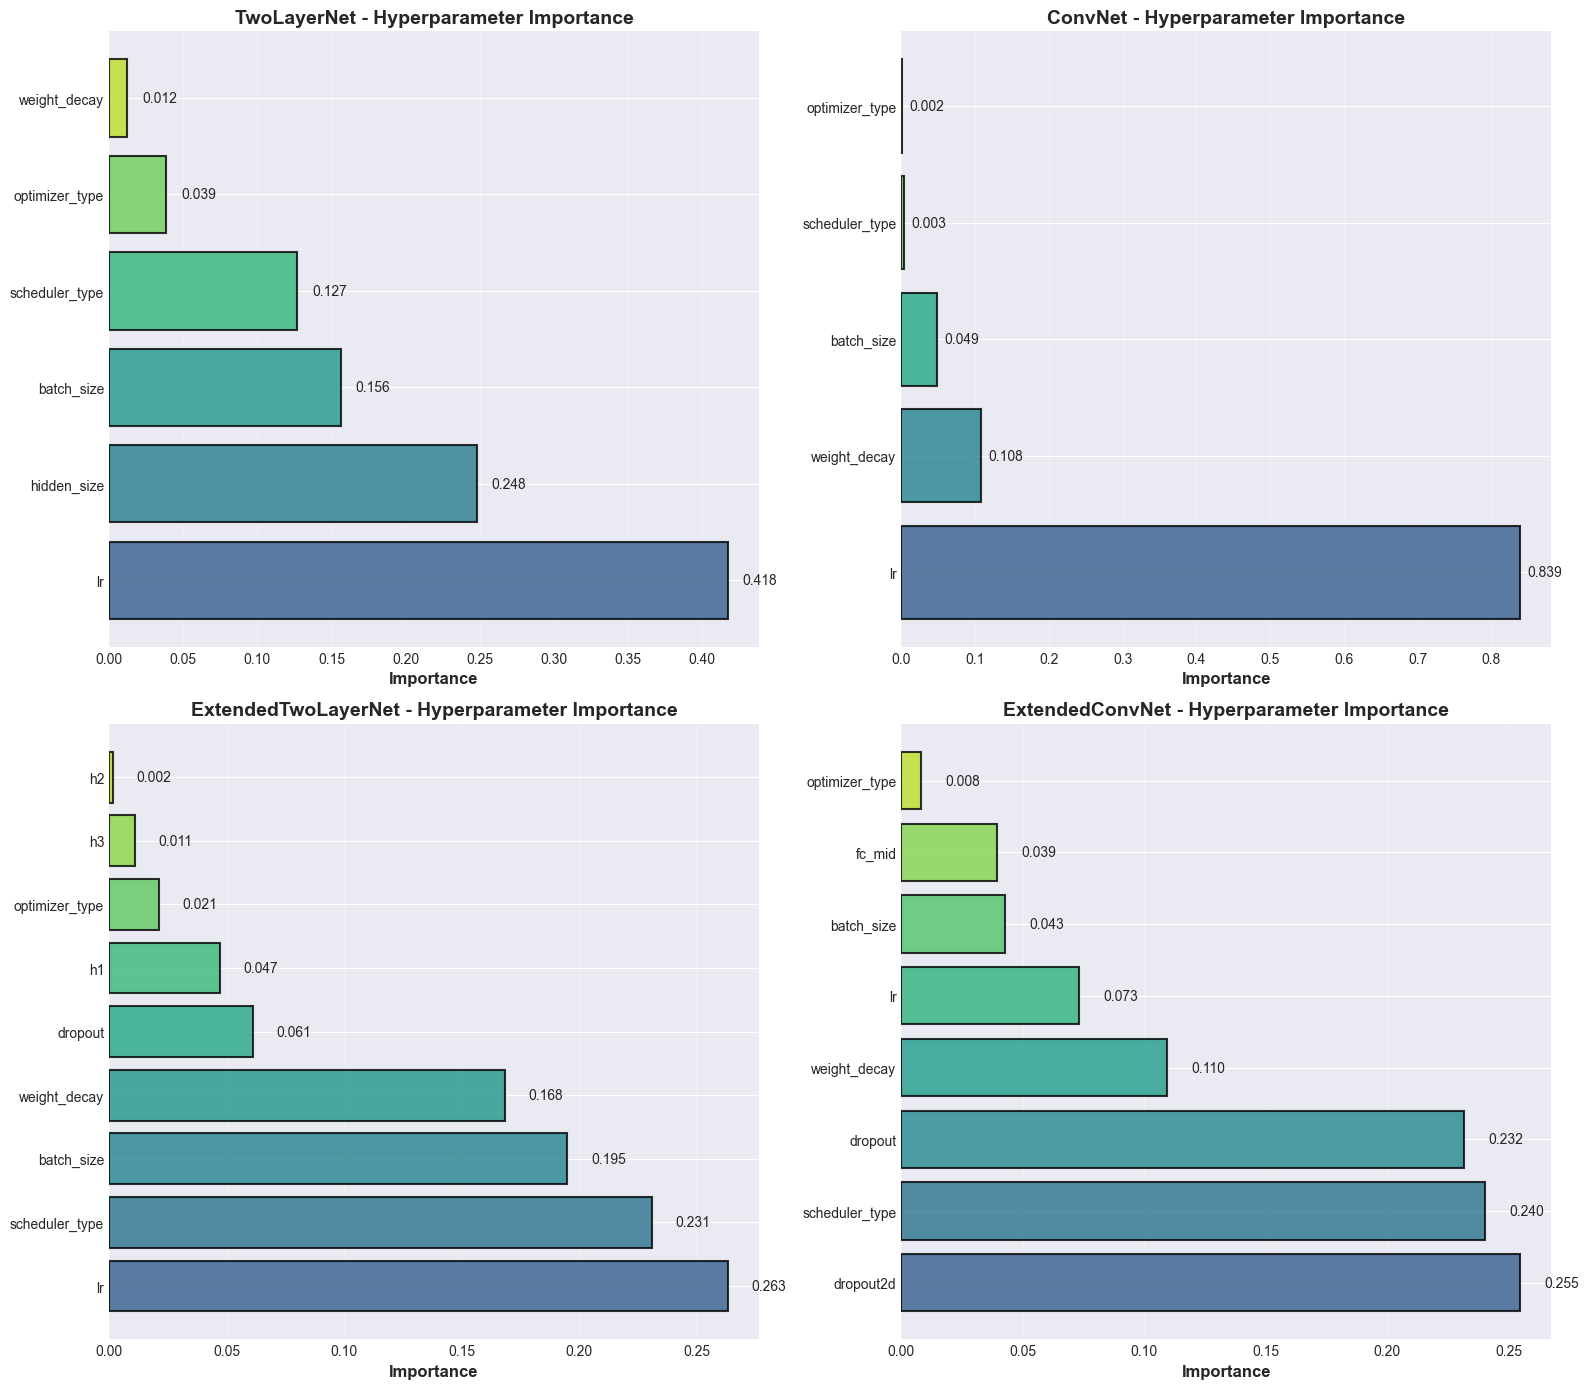

Figure saved as 'optuna_hyperparameter_importance.png'


In [118]:
# Visualize hyperparameter importance for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (model_name, study) in enumerate(studies.items()):
    ax = axes[idx]
    
    try:
        # Get hyperparameter importance
        importance = optuna.importance.get_param_importances(study)
        
        # Create bar plot
        params = list(importance.keys())
        values = list(importance.values())
        
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(params)))
        bars = ax.barh(params, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
        ax.set_title(f'{model_name} - Hyperparameter Importance', 
                     fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for bar, val in zip(bars, values):
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                    f'{val:.3f}',
                    ha='left', va='center', fontsize=10)
    
    except Exception as e:
        ax.text(0.5, 0.5, f'Not enough data\nfor importance analysis',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{model_name} - Hyperparameter Importance', 
                     fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('optuna_hyperparameter_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'optuna_hyperparameter_importance.png'")


## 5. Final Test Set Evaluation from Best Checkpoints

Load the best checkpoints saved during training and evaluate them on the test set to get the final performance metrics.


In [119]:
# Model architectures are imported from models.py
# This ensures we use the exact same architectures that were used during training

print("Model architectures imported from models.py")


Model architectures imported from models.py


In [120]:
# Load CIFAR-100 test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Get class names
class_names = test_dataset.classes

print(f"Test dataset loaded: {len(test_dataset)} samples")
print(f"Number of classes: {len(class_names)}")


Files already downloaded and verified
Test dataset loaded: 10000 samples
Number of classes: 100


In [121]:
# Helper function to build models with correct hyperparameters
def build_model_from_params(model_name, params):
    """Build a model instance given the model name and hyperparameters."""
    if model_name == 'TwoLayerNet':
        return TwoLayerNet(
            input_size=3*32*32,
            hidden_size=params['hidden_size'],
            num_classes=100
        )
    elif model_name == 'ConvNet':
        return ConvNet()
    elif model_name == 'ExtendedTwoLayerNet':
        return ExtendedTwoLayerNet(
            h1=params['h1'],
            h2=params['h2'],
            h3=params['h3'],
            dropout=params['dropout']
        )
    elif model_name == 'ExtendedConvNet':
        return ExtendedConvNet(
            fc_mid=params['fc_mid'],
            dropout=params['dropout']
        )
    else:
        raise ValueError(f"Unknown model name: {model_name}")

# Function to evaluate model and get per-class accuracy
def evaluate_model_detailed(model, test_loader, device='cpu'):
    """Evaluate model and return overall accuracy and per-class accuracies."""
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0
    class_correct = np.zeros(100)
    class_total = np.zeros(100)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class statistics
            for label, pred in zip(labels, predicted):
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    overall_acc = 100 * correct / total
    class_acc = 100 * class_correct / (class_total + 1e-10)
    
    return overall_acc, class_acc, np.array(all_preds), np.array(all_labels)

print("Helper functions defined successfully")


Helper functions defined successfully


In [122]:
# Load and evaluate all models from checkpoints
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

checkpoint_dir = 'checkpoints'
model_results = {}

for model_name, study in studies.items():
    print(f"Evaluating {model_name}...")
    
    try:
        # Get best hyperparameters
        best_params = study.best_params
        
        # Build model with correct architecture
        model = build_model_from_params(model_name, best_params)
        
        # Load checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'{model_name.lower()}_final_best.pth')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state'])
            checkpoint_epoch = checkpoint['epoch']
            checkpoint_val_acc = checkpoint['val_acc']
            
            # Evaluate on test set
            test_acc, class_acc, all_preds, all_labels = evaluate_model_detailed(model, test_loader, device)
            
            model_results[model_name] = {
                'test_accuracy': test_acc,
                'class_accuracy': class_acc,
                'checkpoint_epoch': checkpoint_epoch,
                'checkpoint_val_acc': checkpoint_val_acc,
                'predictions': all_preds,
                'labels': all_labels,
                'best_params': best_params
            }
            
            print(f"  Checkpoint from epoch {checkpoint_epoch}")
            print(f"  Validation accuracy (at checkpoint): {checkpoint_val_acc:.2f}%")
            print(f"  Test accuracy (final evaluation): {test_acc:.2f}%")
            print(f"  Class accuracy range: {class_acc.min():.2f}% - {class_acc.max():.2f}%\n")
        else:
            print(f"  Checkpoint not found: {checkpoint_path}\n")
            
    except Exception as e:
        print(f"  Error evaluating {model_name}: {e}\n")

print("="*80)
print("Evaluation complete!")


Using device: cpu

Evaluating TwoLayerNet...
  Checkpoint from epoch 100
  Validation accuracy (at checkpoint): 29.88%
  Test accuracy (final evaluation): 29.88%
  Class accuracy range: 6.00% - 82.00%

Evaluating ConvNet...
  Checkpoint from epoch 73
  Validation accuracy (at checkpoint): 30.61%
  Test accuracy (final evaluation): 30.61%
  Class accuracy range: 1.00% - 76.00%

Evaluating ExtendedTwoLayerNet...
  Checkpoint from epoch 83
  Validation accuracy (at checkpoint): 33.93%
  Test accuracy (final evaluation): 33.93%
  Class accuracy range: 6.00% - 77.00%

Evaluating ExtendedConvNet...
  Checkpoint from epoch 100
  Validation accuracy (at checkpoint): 52.94%
  Test accuracy (final evaluation): 52.94%
  Class accuracy range: 16.00% - 88.00%

Evaluation complete!


### 5.1 Final Test Set Performance

This shows the test set accuracy achieved by loading the best checkpoint for each model.


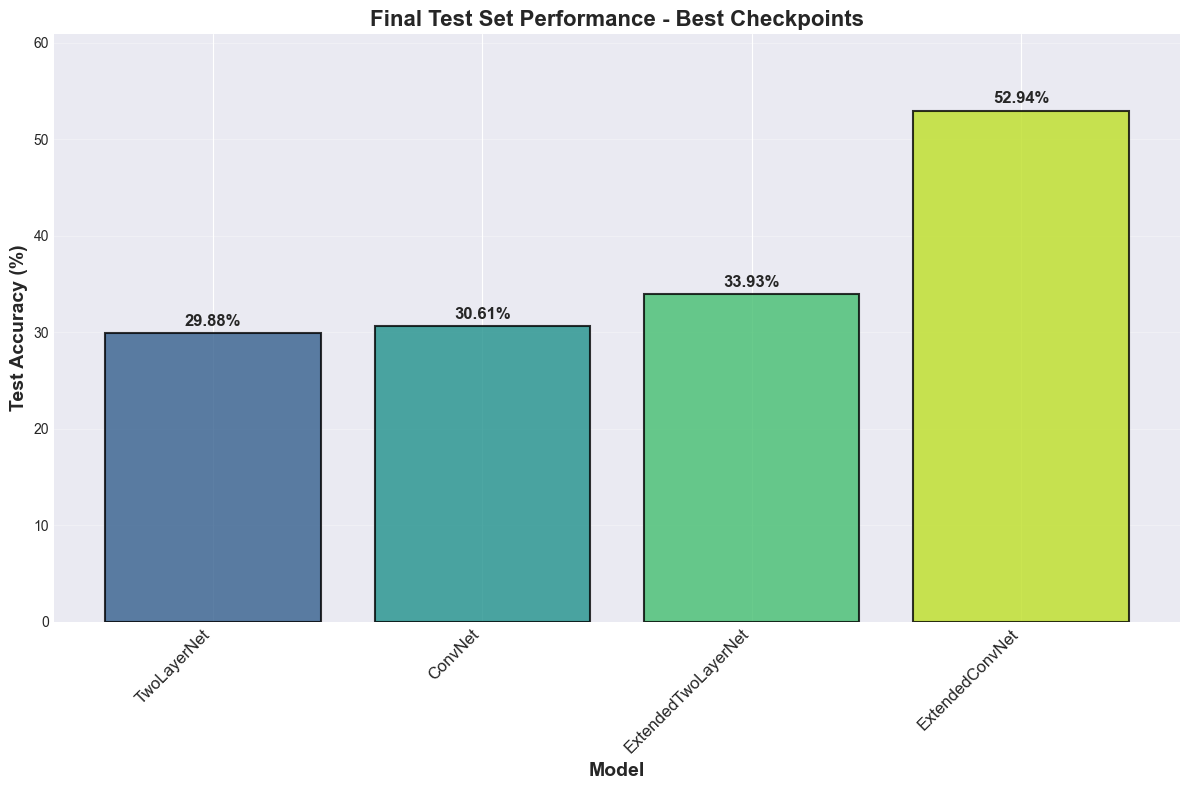

Figure saved as 'final_test_accuracy_comparison.png'


In [123]:
# Compare final test accuracies
fig, ax = plt.subplots(figsize=(12, 8))

model_names_list = list(model_results.keys())
test_accs = [model_results[m]['test_accuracy'] for m in model_names_list]

x = np.arange(len(model_names_list))

# Create bar plot with gradient colors
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(model_names_list)))

bars = ax.bar(x, test_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on top of bars
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Final Test Set Performance - Best Checkpoints', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names_list, rotation=45, ha='right', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(test_accs) * 1.15)

plt.tight_layout()
plt.savefig('final_test_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'final_test_accuracy_comparison.png'")


## 6. Per-Class Performance Analysis

Analyze which classes are easiest and hardest for each model to classify.


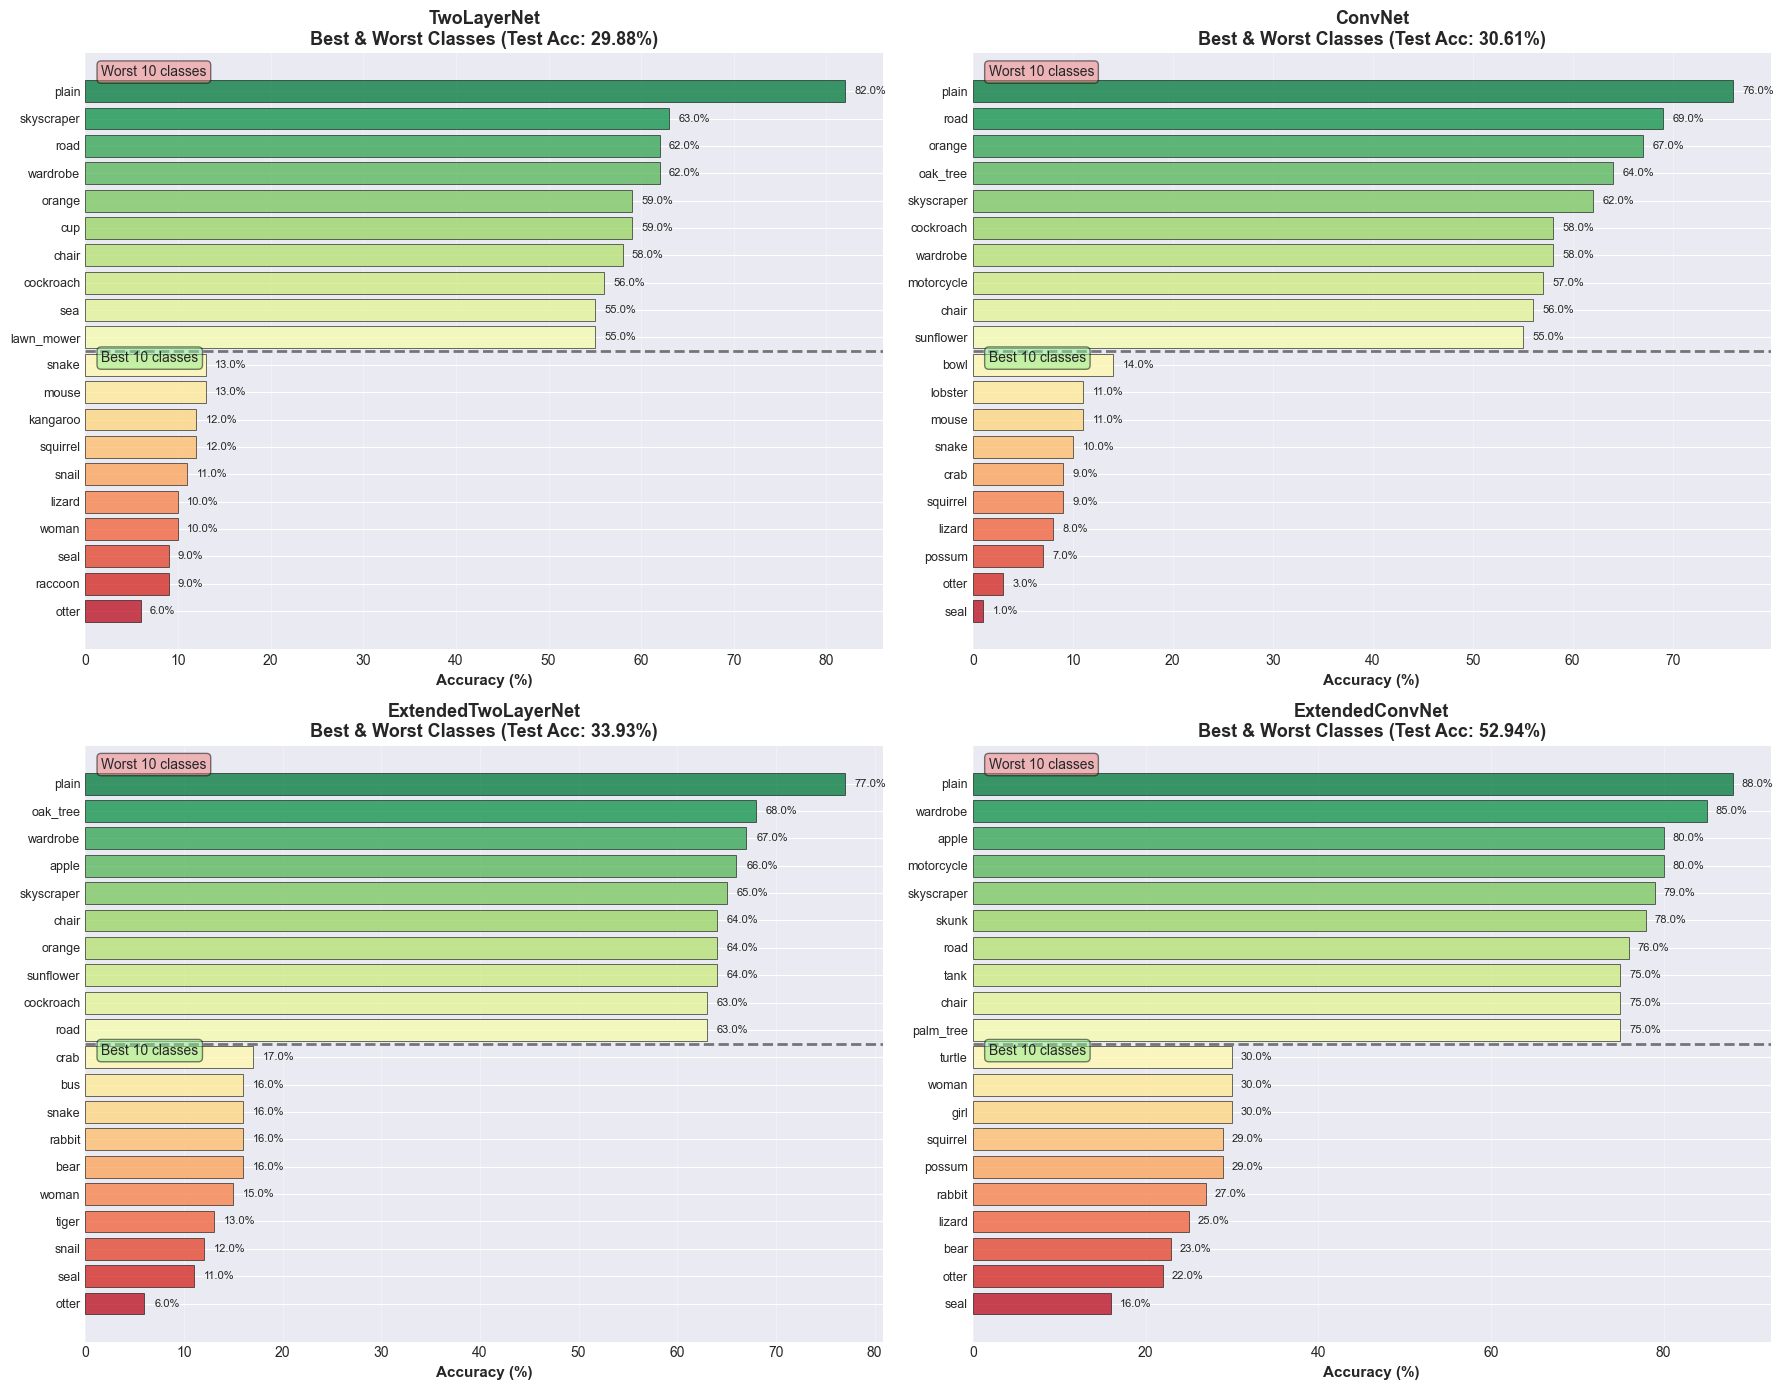

Figure saved as 'per_class_performance_analysis.png'


In [124]:
# Show top-10 best and worst performing classes for each model
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, (model_name, results) in enumerate(model_results.items()):
    ax = axes[idx]
    
    class_acc = results['class_accuracy']
    
    # Get top 10 and bottom 10 classes
    sorted_indices = np.argsort(class_acc)
    worst_10 = sorted_indices[:10]
    best_10 = sorted_indices[-10:]
    
    # Combine for display
    display_indices = np.concatenate([worst_10, best_10])
    display_acc = class_acc[display_indices]
    display_names = [class_names[i][:15] for i in display_indices]  # Truncate long names
    
    # Create color map (red for worst, green for best)
    colors = ['red'] * 10 + ['green'] * 10
    colors_gradient = sns.color_palette("RdYlGn", n_colors=20)
    
    # Create horizontal bar plot
    y_pos = np.arange(len(display_names))
    bars = ax.barh(y_pos, display_acc, color=colors_gradient, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(display_names, fontsize=9)
    ax.set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nBest & Worst Classes (Test Acc: {results["test_accuracy"]:.2f}%)', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.axhline(y=9.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
    
    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars, display_acc)):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{acc:.1f}%',
                ha='left', va='center', fontsize=8)
    
    # Add legend
    ax.text(0.02, 0.98, 'Worst 10 classes', transform=ax.transAxes,
            fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    ax.text(0.02, 0.50, 'Best 10 classes', transform=ax.transAxes,
            fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.savefig('per_class_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'per_class_performance_analysis.png'")


### 6.1 Cross-Model Class Performance Heatmap

Visualize which classes are universally easy or hard across all models.


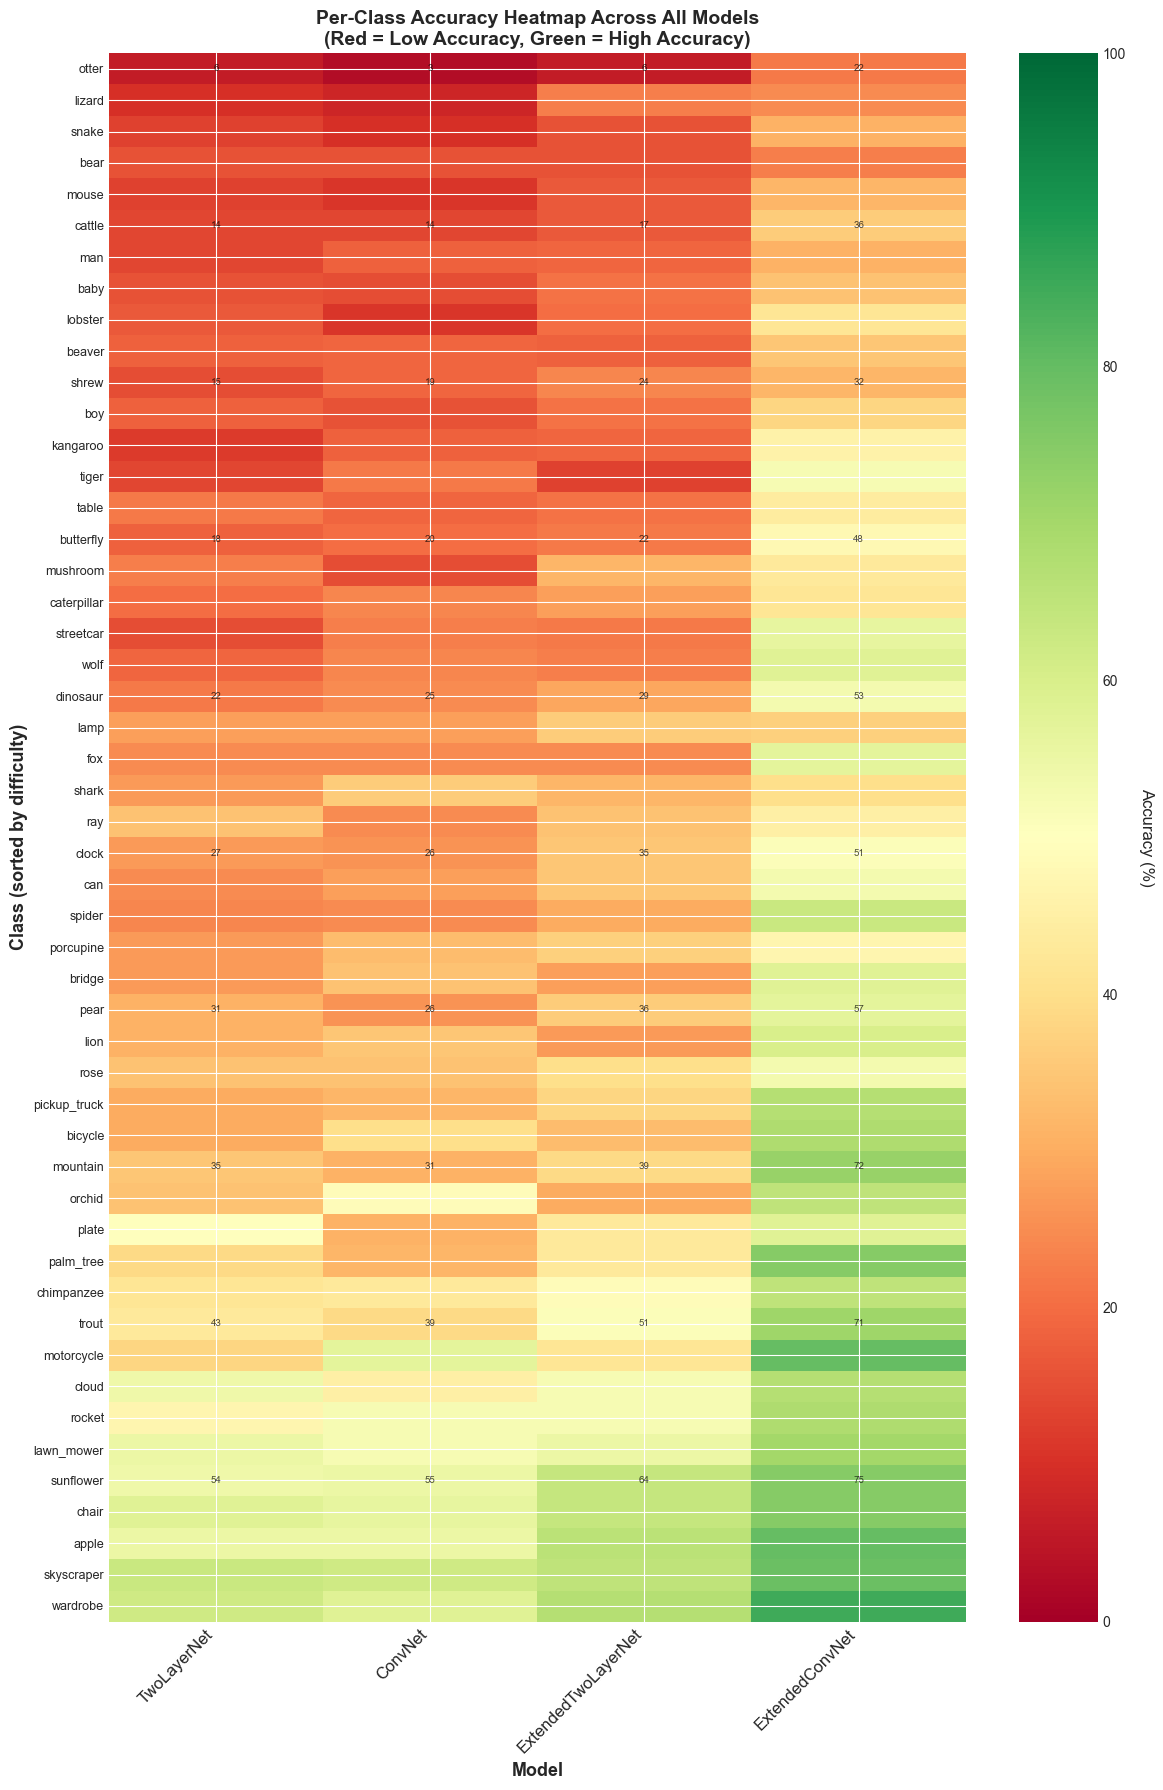

Figure saved as 'class_accuracy_heatmap.png'


In [125]:
# Create heatmap of per-class accuracy across all models
# Prepare data
class_acc_matrix = np.zeros((len(class_names), len(model_results)))
model_names_list = list(model_results.keys())

for i, model_name in enumerate(model_names_list):
    class_acc_matrix[:, i] = model_results[model_name]['class_accuracy']

# Calculate average accuracy per class
avg_class_acc = class_acc_matrix.mean(axis=1)

# Sort classes by average accuracy (to group similar difficulty classes)
sorted_class_indices = np.argsort(avg_class_acc)

# Select a subset of classes for better visualization (e.g., every 2nd class)
# Or show all if the figure is large enough
step = 2 if len(class_names) > 50 else 1
display_indices = sorted_class_indices[::step]

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 18))

heatmap_data = class_acc_matrix[display_indices, :]
display_class_names = [class_names[i][:20] for i in display_indices]

im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Set ticks and labels
ax.set_xticks(np.arange(len(model_names_list)))
ax.set_yticks(np.arange(len(display_indices)))
ax.set_xticklabels(model_names_list, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(display_class_names, fontsize=9)

ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_ylabel('Class (sorted by difficulty)', fontsize=13, fontweight='bold')
ax.set_title('Per-Class Accuracy Heatmap Across All Models\n(Red = Low Accuracy, Green = High Accuracy)', 
             fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Accuracy (%)', rotation=270, labelpad=20, fontsize=12)

# Add text annotations for selected cells
for i in range(0, len(display_indices), 5):  # Annotate every 5th row to avoid clutter
    for j in range(len(model_names_list)):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.0f}',
                      ha="center", va="center", color="black", fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('class_accuracy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'class_accuracy_heatmap.png'")


## 7. Summary Table

Comprehensive summary of all model results.


In [126]:
# Create comprehensive summary table
summary_data = []

for model_name, results in model_results.items():
    class_acc = results['class_accuracy']
    
    summary_data.append({
        'Model': model_name,
        'Best Val Acc (%)': f"{results['checkpoint_val_acc']:.2f}",
        'Final Test Acc (%)': f"{results['test_accuracy']:.2f}",
        'Checkpoint Epoch': results['checkpoint_epoch'],
        'Best Class Acc (%)': f"{class_acc.max():.2f}",
        'Worst Class Acc (%)': f"{class_acc.min():.2f}",
        'Avg Class Acc (%)': f"{class_acc.mean():.2f}",
        'Class Acc Std (%)': f"{class_acc.std():.2f}"
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*120)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*120)
print(summary_df.to_string(index=False))
print("="*120)

# Additional analysis
print("\n" + "="*120)
print("INSIGHTS")
print("="*120)

# Find best overall model
best_model_name = max(model_results.keys(), key=lambda m: model_results[m]['test_accuracy'])
best_test_acc = model_results[best_model_name]['test_accuracy']
print(f"\nBest Performing Model: {best_model_name} ({best_test_acc:.2f}% test accuracy)")

# Find classes that are universally hard/easy
avg_class_acc = class_acc_matrix.mean(axis=1)
hardest_classes = np.argsort(avg_class_acc)[:5]
easiest_classes = np.argsort(avg_class_acc)[-5:]

print(f"\n5 Hardest Classes (across all models):")
for idx in hardest_classes:
    print(f"  - {class_names[idx]}: {avg_class_acc[idx]:.2f}% avg accuracy")

print(f"\n5 Easiest Classes (across all models):")
for idx in easiest_classes:
    print(f"  - {class_names[idx]}: {avg_class_acc[idx]:.2f}% avg accuracy")

# Baseline vs Extended comparison
if 'TwoLayerNet' in model_results and 'ExtendedTwoLayerNet' in model_results:
    improvement_fc = model_results['ExtendedTwoLayerNet']['test_accuracy'] - model_results['TwoLayerNet']['test_accuracy']
    print(f"\nExtendedTwoLayerNet improvement over TwoLayerNet: {improvement_fc:+.2f}%")

if 'ConvNet' in model_results and 'ExtendedConvNet' in model_results:
    improvement_conv = model_results['ExtendedConvNet']['test_accuracy'] - model_results['ConvNet']['test_accuracy']
    print(f"ExtendedConvNet improvement over ConvNet: {improvement_conv:+.2f}%")

print("="*120)

# Save summary to CSV
summary_df.to_csv('model_performance_summary.csv', index=False)
print("\nSummary table saved to 'model_performance_summary.csv'")



COMPREHENSIVE MODEL PERFORMANCE SUMMARY
              Model Best Val Acc (%) Final Test Acc (%)  Checkpoint Epoch Best Class Acc (%) Worst Class Acc (%) Avg Class Acc (%) Class Acc Std (%)
        TwoLayerNet            29.88              29.88               100              82.00                6.00             29.88             15.70
            ConvNet            30.61              30.61                73              76.00                1.00             30.61             15.71
ExtendedTwoLayerNet            33.93              33.93                83              77.00                6.00             33.93             15.58
    ExtendedConvNet            52.94              52.94               100              88.00               16.00             52.94             16.15

INSIGHTS

Best Performing Model: ExtendedConvNet (52.94% test accuracy)

5 Hardest Classes (across all models):
  - otter: 9.25% avg accuracy
  - seal: 9.25% avg accuracy
  - lizard: 16.50% avg accuracy
  - possum